In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
from pprint import pprint
import json
from bs4 import BeautifulSoup
from urllib.parse import urlencode
import re

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import mplcyberpunk
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from typing import List, Dict, Callable

# plt.style.use('ggplot')
plt.style.use("cyberpunk")

import os
os.getcwd()

'/home/jovyan/work/Fraud_Detection'

In [27]:
# Import Custom Modules
from src.cleaner import *

In [4]:
# Import Data
data = pd.read_json('data/data.json')

In [5]:
# Clean Data
cleaned_data = clean_with_target(data)

# Preview Data
cleaned_data.head(2)

,channels,country,currency,delivery_method,email_domain,event_start,fb_published,has_logo,listed,payee_name,previous_payouts,user_type,venue_country,venue_latitude,venue_longitude,fraud
0,5,US,USD,0.0,gmail.com,1265594400,0,0,y,,[],1,US,25.777471,-80.133433,1
1,0,US,USD,1.0,ruf.org,1296255600,0,1,n,RUF,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",3,US,32.776566,-79.930922,0


# Featurize for KNN Model

In [42]:
def readd_features(data:pd.DataFrame, data2:pd.DataFrame) -> pd.DataFrame:
    """ Adds wanted features back from original dataframe """
    res = data.copy()
    from_ = data2.copy()
    
    res['event_created'] = from_['event_created']
    res['event_end'] = from_['event_end']
    res['event_published'] = from_['event_published']
    res['user_created'] = from_['user_created']
    

    return res

def create_features(data:pd.DataFrame) -> pd.DataFrame:
    """ Creates features from given data geared towards KNN Model """
    
    res = data.copy()
    # 'listed' col to binary
    res['listed'] = res['listed'].apply(lambda x: 0 if x == 'y' else 1)
#     # 'previous_payments' to n_previous_payments
#     res['n_previous_payouts'] = res['previous_payouts'].apply(lambda x: len(x))
#     res.drop(columns='previous_payouts', inplace=True)
    # 'country' feature to 'None' instead of nan
    res['country'] = res['country'].fillna('None')
    
    # Durations (create durations between event_created/start/end/publish)
    res['event_duration'] = res['event_end'] - res['event_start']
    res['event_till_publish'] = res['event_published'] - res['event_created']
    res['user_event_lifespan'] = res['event_created'] - res['user_created']
    res.drop(columns=['event_created', 'event_published', 'event_start', 'event_end'], inplace=True)
    
    return res

In [7]:
# Re-add Missing Features
cleaned_data = readd_features(cleaned_data, data)
# Final Cleaning
cleaned_data = create_features(cleaned_data)

In [8]:
cleaned_data.head(2)

,channels,country,currency,delivery_method,email_domain,fb_published,has_logo,listed,payee_name,user_type,venue_country,venue_latitude,venue_longitude,fraud,user_created,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan
0,5,US,USD,0.0,gmail.com,0,0,0,,1,US,25.777471,-80.133433,1,1259613950,0,36000,370132.0,3125756
1,0,US,USD,1.0,ruf.org,0,1,1,RUF,3,US,32.776566,-79.930922,0,1280942776,49,32400,625.0,12889894


# Visualizations

In [9]:
# Global Series to use in Visualizations
fraud = cleaned_data[cleaned_data['fraud'] == 1]
legit = cleaned_data[cleaned_data['fraud'] == 0]
event_groups = cleaned_data.groupby('fraud')

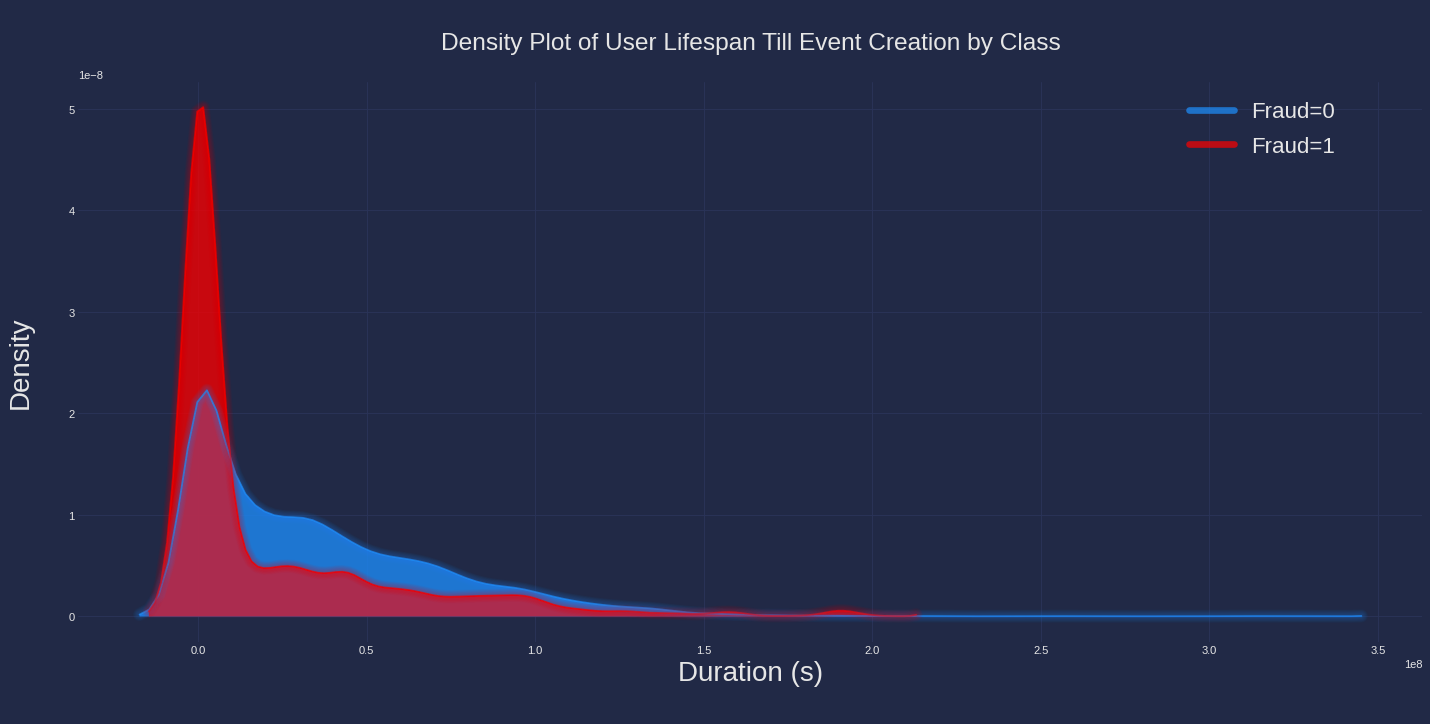

In [13]:
# Create A Fraud vs User to Event Lifespan Dist

# Draw Plot
plt.figure(figsize=(14,7), dpi= 80)

alpha_col = 0.7
colors = ["dodgerblue", "red"]
classification = sorted(cleaned_data["fraud"].unique())

# Plot Points
for col, class_ in zip(colors, classification):
    sns.kdeplot(cleaned_data.loc[cleaned_data['fraud'] == class_, "user_event_lifespan"], shade=True, color=col, label=f"Fraud={class_}", alpha=.7)

# Decoration
plt.title('\nDensity Plot of User Lifespan Till Event Creation by Class\n', fontsize=22)
plt.xlabel("Duration (s)\n", fontsize=25)
plt.ylabel("Density\n", fontsize=25)
legend_ = plt.legend(loc="upper right", bbox_to_anchor=(0.45, 0.5, 0.5, 0.5), fontsize=20, labelspacing=0.6)
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

# Increase Label Line Thickness
for line in legend_.get_lines():
    line.set_linewidth(6)

# Set Limits


# Show Plot
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=1, hspace=0)
plt.show()

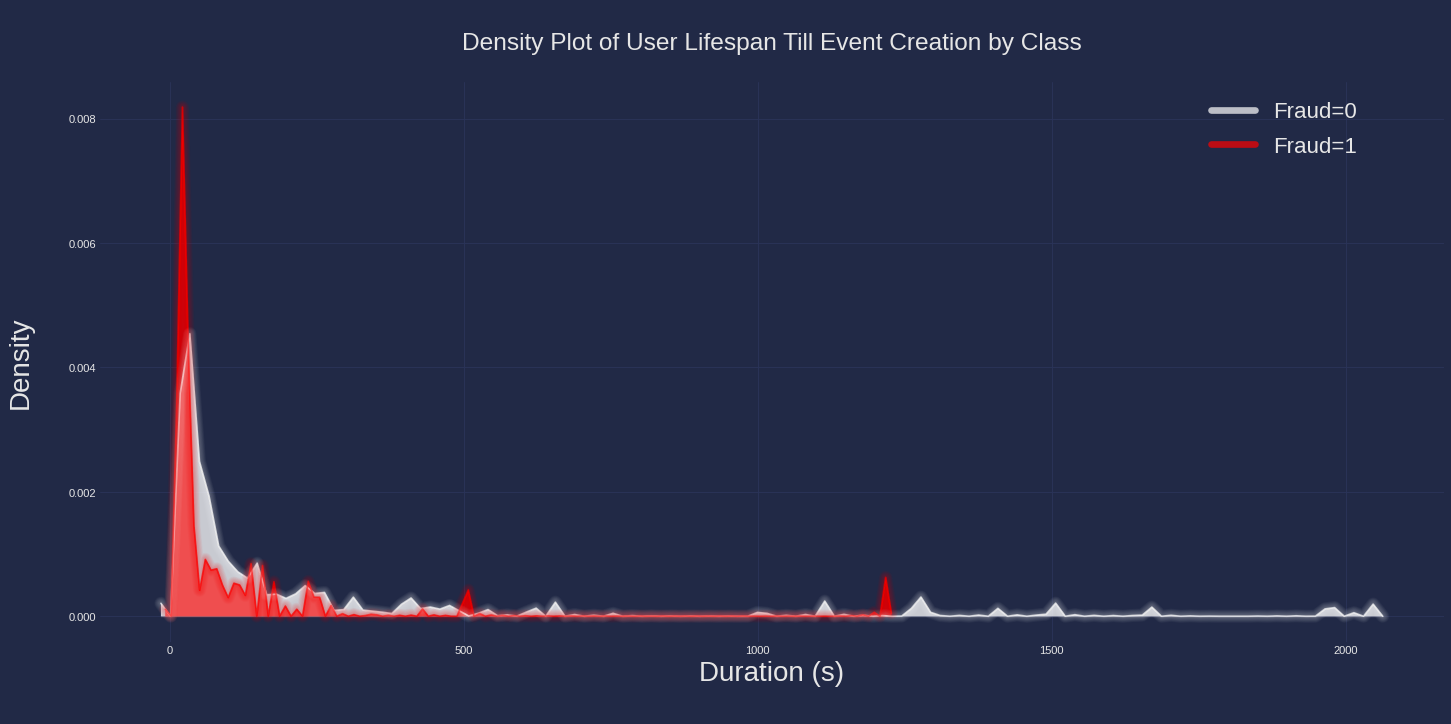

In [18]:
# Create A Fraud vs User to Event Lifespan Dist

# Draw Plot
plt.figure(figsize=(14,7), dpi= 80)

alpha_col = 0.7
colors = ["white", "red"]
classification = sorted(cleaned_data["fraud"].unique())

# Plot Points
for col, class_ in zip(colors, classification):
    sns.kdeplot(cleaned_data.loc[cleaned_data['fraud'] == class_, "n_previous_payouts"], shade=True, color=col, label=f"Fraud={class_}", alpha=.7)

# Decoration
plt.title('\nDensity Plot of User Lifespan Till Event Creation by Class\n', fontsize=22)
plt.xlabel("Duration (s)\n", fontsize=25)
plt.ylabel("Density\n", fontsize=25)
legend_ = plt.legend(loc="upper right", bbox_to_anchor=(0.45, 0.5, 0.5, 0.5), fontsize=20, labelspacing=0.6)
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()

# Increase Label Line Thickness
for line in legend_.get_lines():
    line.set_linewidth(6)

# Set Limits


# Show Plot
plt.subplots_adjust(left=0, bottom=0, right=1.2, top=1, wspace=1, hspace=0)
plt.show()

# KNN Modeling

# Check API Data

In [38]:
from src.api_client import *

event_api = EventAPIClient()

def _call(client:object) -> pd.DataFrame:
    return client.get_data()

sample_call = _call(event_api)

# pprint(sample_call[0])

sample_df = pd.DataFrame(sample_call)

In [41]:
sample_df['description'][0]

'<p class="MsoNormal" style="text-align: center;">&nbsp;<span style="font-family: arial,helvetica,sans-serif; font-size: medium;">Choose Your Legal Entity</span></p>\r\n<p class="MsoNormal" style="margin: 0in 0in 0pt; mso-layout-grid-align: none;"><span style="font-family: \'Calibri\',\'sans-serif\'; mso-bidi-font-family: AGaramond-Regular;"><span style="font-size: medium;">Make it legal!<span style="mso-spacerun: yes;">&nbsp; </span>A legal designation can significantly impact the future of your business, so come to:</span></span></p>\r\n<p class="MsoNormal">&nbsp;</p>\r\n<p class="MsoNormal" style="margin: 0in 0in 0pt 39pt; text-indent: -0.25in; mso-list: l0 level1 lfo1; tab-stops: list 39.0pt; mso-layout-grid-align: none;"><span style="font-family: Symbol; font-size: 10pt; mso-fareast-font-family: Symbol; mso-bidi-font-family: Symbol;"><span style="mso-list: Ignore;">&middot;<span style="font: 7pt/normal \'Times New Roman\'; font-size-adjust: none; font-stretch: normal;">&nbsp;&nbsp